In [1]:
import numpy as np
import pandas as pd
import importlib
import random
import simulate_data
from matplotlib import pyplot as plt
from scipy.stats import beta
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from econml.grf import CausalForest
from econml.metalearners import SLearner, TLearner

importlib.reload(simulate_data)

<module 'simulate_data' from 'D:\\Delft\\Year 3\\Q4\\code\\research-project\\simulate_data.py'>

# Example Simulation
Balanced case with simple CATE

In [54]:
e = lambda x: 0.5
d = 5
weights = np.random.uniform(-5, 5, d)
mu_0 = lambda x: np.dot(x, weights) #+ 5 * (1 if x[0] > 0.5 else 0)
mu_1 = lambda x: mu_0(x) + 20 #+ 8 * (1 if x[1] > 0.5 else 0)
n = 20000

sim = pd.DataFrame(simulate_data.get_training_set(d, mu_0, mu_1, e, n))

sim_y = sim["Y"]
sim_w = sim["W"]
sim_x = pd.DataFrame(sim["X"].tolist(), index = sim.index)
sim_x.columns = sim_x.columns.astype(str)
sim_x_s = sim_x.assign(W=pd.Series(sim_w).values)

sim_x_t_0 = pd.DataFrame(sim.query("W==0")["X"].tolist())
sim_x_t_0.columns = sim_x_t_0.columns.astype(str)
sim_x_t_1 = pd.DataFrame(sim.query("W==1")["X"].tolist())
sim_x_t_1.columns = sim_x_t_1.columns.astype(str)

print(sim_y[0])

sim_x_t_0

32.14076305731383


,0,1,2,3,4
0,-0.888706,1.108492,0.062270,0.062053,1.414643
1,1.033120,-0.523087,-1.173457,-0.554226,1.571090
2,0.019887,0.590836,0.605136,-1.166513,-0.012824
3,0.115710,-1.410322,-0.745252,-0.944909,0.430055
4,0.498579,-0.125971,-0.942222,-2.207569,0.509391
...,...,...,...,...,...
9937,1.997611,-1.726047,-0.321595,0.805199,1.284839
9938,3.171354,-0.400765,-1.539856,-1.556363,0.137856
9939,-1.129728,1.264382,-0.677764,-0.964289,-1.761771
9940,-0.584725,2.111882,0.681115,0.325564,1.046187


## S-learner

In [55]:
# regr = RandomForestRegressor(n_estimators=30, min_samples_split=10)
regr = RandomForestRegressor()
# regr = LinearRegression()
regr.fit(sim_x_s, sim_y)

y_fitted = regr.predict(sim_x_s)
print(y_fitted[0])
mean_squared_error(sim_y, y_fitted)

31.56020250274385


0.09211939536322321

In [56]:
sim_test = pd.DataFrame(simulate_data.get_test_set(d, mu_0, mu_1, e, 1000))

sim_test_x = pd.DataFrame(sim_test["X"].tolist(), index=sim_test.index)
sim_test_x.columns = sim_test_x.columns.astype(str)

test_sim_x_0 = sim_test_x.assign(**{"W": 0})
test_sim_x_1 = sim_test_x.assign(**{"W": 1})
test_sim_y = np.append(sim_test["Y0"], sim_test["Y1"])

y_test_pred = regr.predict(pd.concat([test_sim_x_0, test_sim_x_1]))
mean_squared_error(test_sim_y, y_test_pred)


0.5866789029071652

In [57]:
# def sensitivity(data, y, t):
#         # line coefficient for the one variable linear regression
#         return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
#                 np.sum((data[t] - data[t].mean())**2))
#
# def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
#     size = dataset.shape[0]
#     ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
#     n_rows = list(range(min_periods, size, size // steps)) + [size]
#
#     ## add (rows/size) as a normalizer.
#     return np.array([sensitivity(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

In [58]:
s_learner_cate_train = (regr.predict(sim_x.assign(**{"W": 1})) -
                        regr.predict(sim_x.assign(**{"W": 0})))

s_learner_cate_test = sim_test_x.assign(
    cate=(regr.predict(sim_test_x.assign(**{"W": 1})) - # predict under treatment
          regr.predict(sim_test_x.assign(**{"W": 0}))) # predict under control
)

In [59]:
s_learner_cate_test

,0,1,2,3,4,cate
0,-0.771047,0.251971,1.789780,0.168026,-1.531579,20.510691
1,-1.127561,1.791100,-0.783444,-1.544364,0.571884,19.950696
2,-0.417667,0.018373,-0.307189,-0.995640,2.027552,19.812381
3,1.576304,-1.215503,-0.039344,-0.067687,-1.348915,18.782853
4,-1.297401,1.823751,-1.800413,0.066009,1.588884,19.964251
...,...,...,...,...,...,...
995,0.375817,0.526260,0.232245,0.576329,0.804988,20.174603
996,1.166141,0.644563,1.166007,-1.950606,0.399443,21.883252
997,-0.496082,-0.619069,0.560800,1.853589,0.219727,19.691834
998,-1.545689,0.215458,0.595084,-0.442092,0.057988,20.265474


In [60]:
mean_squared_error(s_learner_cate_test.cate, sim_test.Y1 - sim_test.Y0)

0.37114414881717667

# T-learner

In [61]:
regr0 = RandomForestRegressor()
regr1 = RandomForestRegressor()

regr0.fit(sim_x_t_0, sim.query("W==0")["Y"])
regr1.fit(sim_x_t_1, sim.query("W==1")["Y"])

t_learner_cate_train = regr1.predict(sim_x) - regr0.predict(sim_x)
t_learner_cate_test = sim_test_x.assign(cate=regr1.predict(sim_test_x) - regr0.predict(sim_test_x))

In [62]:
t_learner_cate_test

,0,1,2,3,4,cate
0,-0.771047,0.251971,1.789780,0.168026,-1.531579,20.192697
1,-1.127561,1.791100,-0.783444,-1.544364,0.571884,19.690535
2,-0.417667,0.018373,-0.307189,-0.995640,2.027552,20.105686
3,1.576304,-1.215503,-0.039344,-0.067687,-1.348915,19.435220
4,-1.297401,1.823751,-1.800413,0.066009,1.588884,19.916734
...,...,...,...,...,...,...
995,0.375817,0.526260,0.232245,0.576329,0.804988,20.106458
996,1.166141,0.644563,1.166007,-1.950606,0.399443,21.361878
997,-0.496082,-0.619069,0.560800,1.853589,0.219727,20.098400
998,-1.545689,0.215458,0.595084,-0.442092,0.057988,20.596356


In [63]:
mean_squared_error(t_learner_cate_test.cate, sim_test.Y1 - sim_test.Y0)

0.35522221714839053

In [64]:
cau_forest = CausalForest()
cau_forest.fit(sim_x, sim_w, sim_y)

ret = cau_forest.predict(sim_test_x)
ret

array([[19.87808907],
       [20.21641995],
       [19.5676801 ],
       [19.81794335],
       [19.73091555],
       [20.14999469],
       [19.82780204],
       [20.12767028],
       [20.11454038],
       [19.97661375],
       [20.15647421],
       [19.75688352],
       [20.5636575 ],
       [20.21848842],
       [20.07557976],
       [19.9604091 ],
       [19.89940285],
       [20.00032416],
       [20.47474845],
       [20.06031008],
       [20.32475008],
       [20.18839114],
       [20.18409967],
       [19.88527079],
       [19.96076146],
       [19.56149191],
       [19.8389261 ],
       [19.83413715],
       [19.8947173 ],
       [20.08172332],
       [20.65462381],
       [19.90533967],
       [20.07270134],
       [19.65943969],
       [20.39238252],
       [20.26467982],
       [19.74789423],
       [19.91333971],
       [21.26963357],
       [20.01265629],
       [19.95526787],
       [19.83961908],
       [20.21450185],
       [20.32685842],
       [19.71911521],
       [19

In [65]:
mean_squared_error(ret, sim_test.Y1 - sim_test.Y0)

0.11542590667870493

SIZE 100
FINISHED S-Learner
FINISHED T-Learner
FINISHED Causal Forest
FINISHED econ s-learner
FINISHED econ t-learner
SIZE 200
FINISHED S-Learner
FINISHED T-Learner
FINISHED Causal Forest
FINISHED econ s-learner
FINISHED econ t-learner
SIZE 300
FINISHED S-Learner
FINISHED T-Learner
FINISHED Causal Forest
FINISHED econ s-learner
FINISHED econ t-learner
SIZE 500
FINISHED S-Learner
FINISHED T-Learner
FINISHED Causal Forest
FINISHED econ s-learner
FINISHED econ t-learner
SIZE 750
FINISHED S-Learner
FINISHED T-Learner
FINISHED Causal Forest
FINISHED econ s-learner
FINISHED econ t-learner
SIZE 1000
FINISHED S-Learner
FINISHED T-Learner
FINISHED Causal Forest
FINISHED econ s-learner
FINISHED econ t-learner
SIZE 2000
FINISHED S-Learner
FINISHED T-Learner
FINISHED Causal Forest
FINISHED econ s-learner
FINISHED econ t-learner
SIZE 5000
FINISHED S-Learner
FINISHED T-Learner
FINISHED Causal Forest
FINISHED econ s-learner
FINISHED econ t-learner
SIZE 10000
FINISHED S-Learner
FINISHED T-Learner
FINI

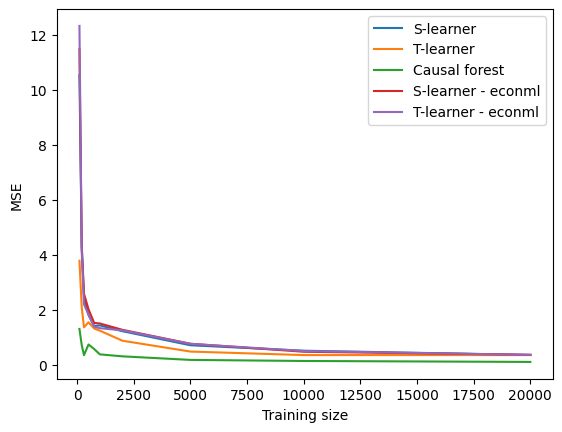

In [66]:
training_sizes = [100, 200, 300, 500, 750, 1000, 2000, 5000, 10000, 20000]
mse_s = []
mse_t = []
mse_forest = []
mse_econml_s = []
mse_econml_t = []
for size in training_sizes:
    print("SIZE " + str(size))
    # S-learner
    regr = RandomForestRegressor()
    regr.fit(sim_x_s.head(size), sim_y.head(size))
    s_learner_cate = sim_test_x.assign(
        cate=(regr.predict(sim_test_x.assign(**{"W": 1})) - # predict under treatment
            regr.predict(sim_test_x.assign(**{"W": 0}))) # predict under control
    )
    mse_s.append(mean_squared_error(s_learner_cate.cate, sim_test.Y1 - sim_test.Y0))
    print("FINISHED S-Learner")

    # T-learner
    regr0 = RandomForestRegressor()
    regr1 = RandomForestRegressor()
    regr0.fit(sim_x_t_0.head(size), sim.query("W==0")["Y"].head(size))
    regr1.fit(sim_x_t_1.head(size), sim.query("W==1")["Y"].head(size))
    t_learner_cate = sim_test_x.assign(cate=regr1.predict(sim_test_x) - regr0.predict(sim_test_x))
    mse_t.append(mean_squared_error(t_learner_cate.cate, sim_test.Y1 - sim_test.Y0))
    print("FINISHED T-Learner")

    # Causal forest
    cau_forest = CausalForest()
    cau_forest.fit(sim_x.head(size), sim_w.head(size), sim_y.head(size))
    causal_forest_cate = cau_forest.predict(sim_test_x)
    mse_forest.append(mean_squared_error(causal_forest_cate, sim_test.Y1 - sim_test.Y0))
    print("FINISHED Causal Forest")

    econml_s = SLearner(overall_model=RandomForestRegressor())
    econml_s.fit(sim_y.head(size), sim_w.head(size), X=sim_x.head(size))
    econml_s_cate = econml_s.effect(sim_test_x)
    mse_econml_s.append(mean_squared_error(econml_s_cate, sim_test.Y1 - sim_test.Y0))
    print("FINISHED econ s-learner")

    econml_t = TLearner(models=RandomForestRegressor())
    econml_t.fit(sim_y.head(size), sim_w.head(size), X=sim_x.head(size))
    econml_t_cate = econml_t.effect(sim_test_x)
    mse_econml_t.append(mean_squared_error(econml_t_cate, sim_test.Y1 - sim_test.Y0))
    print("FINISHED econ t-learner")

plt.plot(training_sizes, mse_s, label="S-learner")
plt.plot(training_sizes, mse_t, label="T-learner")
plt.plot(training_sizes, mse_forest, label="Causal forest")
plt.plot(training_sizes, mse_econml_s, label="S-learner - econml")
plt.plot(training_sizes, mse_econml_t, label="T-learner - econml")
plt.ylabel("MSE")
plt.xlabel("Training size")
plt.legend()
plt.show()

# Testing setup

In [2]:
def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([elast(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

def elast(data, y, t):
        return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
                np.sum((data[t] - data[t].mean())**2))

In [3]:
def train_and_evaluate(train, test, train_x_t_0_head, train_x_t_1_head):

    train_x = pd.DataFrame(train["X"].tolist(), index = train.index)
    train_x.columns = train_x.columns.astype(str)
    train_y = train["Y"]
    train_w = train["W"]

    train_x_s = train_x.assign(W=pd.Series(train_w).values)
    train_x_t_0 = pd.DataFrame(train.query("W==0")["X"].tolist())
    train_x_t_0.columns = train_x_t_0.columns.astype(str)
    train_y_t_0 = train.query("W==0")["Y"]
    if train_x_t_0.shape[0] == 0:
        row = train_x_t_0_head
        train_x_t_0 = pd.DataFrame(row["X"].tolist())
        train_x_t_0.columns = train_x_t_0.columns.astype(str)
        train_y_t_0 = row["Y"]

    train_x_t_1 = pd.DataFrame(train.query("W==1")["X"].tolist())
    train_x_t_1.columns = train_x_t_1.columns.astype(str)
    train_y_t_1 = train.query("W==1")["Y"]
    if train_x_t_1.shape[0] == 0:
        row = train_x_t_1_head
        train_x_t_1 = pd.DataFrame(row["X"].tolist())
        train_x_t_1.columns = train_x_t_1.columns.astype(str)
        train_y_t_1 = row["Y"]

    test_x = pd.DataFrame(test["X"].tolist(), index=test.index)
    test_x.columns = test_x.columns.astype(str)

    true_test_cate = test.Y1 - test.Y0
    # print("COPIED TABLES")

    # S-learner
    regr = RandomForestRegressor()
    regr.fit(train_x_s, train_y)

    s_learner_cate = regr.predict(test_x.assign(**{"W": 1})) - regr.predict(test_x.assign(**{"W": 0}))

    mse_s = mean_squared_error(s_learner_cate, true_test_cate)

    # print("TRAINED S-LEARNER")

    # T-learner
    regr0 = RandomForestRegressor()
    regr1 = RandomForestRegressor()
    regr0.fit(train_x_t_0, train_y_t_0)
    regr1.fit(train_x_t_1, train_y_t_1)

    t_learner_cate = regr1.predict(test_x) - regr0.predict(test_x)
    mse_t = mean_squared_error(t_learner_cate, true_test_cate)
    # print("TRAINED T-LEARNER")

    # Causal forest
    cau_forest = CausalForest()
    cau_forest.fit(train_x, train_w, train_y)

    causal_forest_cate = cau_forest.predict(test_x)
    mse_forest = mean_squared_error(causal_forest_cate, true_test_cate)

    # K Nearest Neighbours
    knn_0 = KNeighborsRegressor(n_neighbors=min(10, train_x_t_0.shape[0]))
    knn_1 = KNeighborsRegressor(n_neighbors=min(10, train_x_t_1.shape[0]))
    knn_0.fit(train_x_t_0, train_y_t_0)
    knn_1.fit(train_x_t_1, train_y_t_1)

    knn_cate = knn_1.predict(test_x) - knn_0.predict(test_x)
    mse_knn = mean_squared_error(knn_cate, true_test_cate)

    return mse_s, mse_t, mse_forest, mse_knn

In [4]:
def run_test(d, mu_0, mu_1, e, n_train, n_test, reps):
    t_s = [0.01, 0.03, 0.05, 0.1, 0.2, 0.5, 1.0]
    training_sizes = [int(n_train * i) for i in t_s]
    mse_s_list = [[] for _ in training_sizes]
    mse_t_list = [[] for _ in training_sizes]
    mse_forest_list = [[] for _ in training_sizes]
    mse_knn_list = [[] for _ in training_sizes]

    for r in range(reps):

        train_full = pd.DataFrame(simulate_data.get_training_set(d, mu_0, mu_1, e, n_train))
        test_full = pd.DataFrame(simulate_data.get_test_set(d, mu_0, mu_1, e, n_test))

        for i, size in enumerate(training_sizes):

            train = train_full.head(size)
            test = test_full

            mse_s, mse_t, mse_forest, mse_knn = train_and_evaluate(train, test, train_full.query("W==0").head(1), train_full.query("W==1").head(1))

            mse_s_list[i].append(mse_s)

            mse_t_list[i].append(mse_t)

            mse_forest_list[i].append(mse_forest)

            mse_knn_list[i].append(mse_knn)

        # mse_s_final.append(np.mean(mse_s))
        # mse_t_final.append(np.mean(mse_t))
        # mse_forest_final.append(np.mean(mse_forest))

    # mse_s_final = list(map(lambda l: np.mean(l), mse_s_list))
    # mse_t_final = list(map(lambda l: np.mean(l), mse_t_list))
    # mse_forest_final = list(map(lambda l: np.mean(l), mse_forest_list))
    #
    #
    # plt.plot(training_sizes, mse_s_final, label="S-learner")
    # plt.plot(training_sizes, mse_t_final, label="T-learner")
    # plt.plot(training_sizes, mse_forest_final, label="Causal forest")
    # plt.ylabel("MSE")
    # plt.xlabel("Training size")
    # plt.legend()
    # plt.show()
    return training_sizes, mse_s_list, mse_t_list, mse_forest_list, mse_knn_list

In [5]:
def plot_mse(training_sizes, mse_s_list, mse_t_list, mse_forest_list, mse_knn_list):
    mse_s_final = list(map(lambda l: np.mean(l), mse_s_list))
    mse_t_final = list(map(lambda l: np.mean(l), mse_t_list))
    mse_forest_final = list(map(lambda l: np.mean(l), mse_forest_list))
    mse_knn_final = list(map(lambda l: np.mean(l), mse_knn_list))

    plt.plot(training_sizes, mse_s_final, label="S-learner")
    plt.plot(training_sizes, mse_t_final, label="T-learner")
    plt.plot(training_sizes, mse_forest_final, label="Causal forest")
    plt.plot(training_sizes, mse_knn_final, label="KNN")
    plt.ylabel("MSE")
    plt.xlabel("Training size")
    plt.legend()
    plt.show()

In [6]:
# def get_conf_intervals(d, mu_0, mu_1, e, n_train, n_test, reps):
#     mse_s_all = []
#     mse_t_all = []
#     mse_forest_all = []
#
#     for i in range(reps):
#         train_full = pd.DataFrame(simulate_data.get_training_set(d, mu_0, mu_1, e, n_train))
#         test_full = pd.DataFrame(simulate_data.get_test_set(d, mu_0, mu_1, e, n_test))
#
#         mse_s, mse_t, mse_forest = train_and_evaluate(train_full, test_full, train_full.query("W==0").head(1), train_full.query("W==1").head(1))
#
#         mse_s_all.append(mse_s)
#         mse_t_all.append(mse_t)
#         mse_forest_all.append(mse_forest)
#
#     data = {"S-Learner": [np.mean(mse_s_all), np.std(mse_s_all, ddof=1)], "T-Learner": [np.mean(mse_t_all), np.std(mse_t_all, ddof=1)], "Causal Forest": [np.mean(mse_forest_all), np.std(mse_forest_all, ddof=1)] }
#
#     return pd.DataFrame.from_dict(data, orient='index', columns=["Mean", "Std dev"])

def get_conf_intervals(mse_s_list, mse_t_list, mse_forest_list, mse_knn_list):
    mse_s_all = mse_s_list[-1]
    mse_t_all = mse_t_list[-1]
    mse_forest_all = mse_forest_list[-1]
    mse_knn_all = mse_knn_list[-1]
    # print(mse_s_all)

    # for i in range(reps):
    #     train_full = pd.DataFrame(simulate_data.get_training_set(d, mu_0, mu_1, e, n_train))
    #     test_full = pd.DataFrame(simulate_data.get_test_set(d, mu_0, mu_1, e, n_test))
    #
    #     mse_s, mse_t, mse_forest = train_and_evaluate(train_full, test_full, train_full.query("W==0").head(1), train_full.query("W==1").head(1))
    #
    #     mse_s_all.append(mse_s)
    #     mse_t_all.append(mse_t)
    #     mse_forest_all.append(mse_forest)

    data = {"S-Learner": [np.mean(mse_s_all), np.std(mse_s_all, ddof=1)], "T-Learner": [np.mean(mse_t_all), np.std(mse_t_all, ddof=1)], "Causal Forest": [np.mean(mse_forest_all), np.std(mse_forest_all, ddof=1)], "KNN": [np.mean(mse_knn_all), np.std(mse_knn_all, ddof=1)] }

    return pd.DataFrame.from_dict(data, orient='index', columns=["Mean", "Std dev"])


In [7]:
def plot_gain_curves(d, mu_0, mu_1, e, n_train, n_test):
    train = pd.DataFrame(simulate_data.get_training_set(d, mu_0, mu_1, e, n_train))
    test = pd.DataFrame(simulate_data.get_test_set(d, mu_0, mu_1, e, n_test))

    train_x = pd.DataFrame(train["X"].tolist(), index = train.index)
    train_x.columns = train_x.columns.astype(str)
    train_y = train["Y"]
    train_w = train["W"]

    train_x_s = train_x.assign(W=pd.Series(train_w).values)

    train_x_t_0 = pd.DataFrame(train.query("W==0")["X"].tolist())
    train_x_t_0.columns = train_x_t_0.columns.astype(str)
    train_y_t_0 = train.query("W==0")["Y"]

    train_x_t_1 = pd.DataFrame(train.query("W==1")["X"].tolist())
    train_x_t_1.columns = train_x_t_1.columns.astype(str)
    train_y_t_1 = train.query("W==1")["Y"]

    test_x = pd.DataFrame(test["X"].tolist(), index=test.index)
    test_x.columns = test_x.columns.astype(str)


    # S-learner
    regr_s = RandomForestRegressor()
    regr_s.fit(train_x_s, train_y)

    # T-learner
    regr0_t = RandomForestRegressor()
    regr1_t = RandomForestRegressor()
    regr0_t.fit(train_x_t_0, train_y_t_0)
    regr1_t.fit(train_x_t_1, train_y_t_1)

    # Causal forest
    cau_forest = CausalForest()
    cau_forest.fit(train_x, train["W"], train["Y"])

    # KNN
    knn_0 = KNeighborsRegressor(n_neighbors=10)
    knn_1 = KNeighborsRegressor(n_neighbors=10)
    knn_0.fit(train_x_t_0, train_y_t_0)
    knn_1.fit(train_x_t_1, train_y_t_1)

    # GET CATE

    s_learner_cate_train = train_x.assign(cate=regr_s.predict(train_x.assign(**{"W": 1})) - regr_s.predict(train_x.assign(**{"W": 0})), W=train_w, Y=train_y)
    s_learner_cate_test = test_x.assign(cate=regr_s.predict(test_x.assign(**{"W": 1})) - regr_s.predict(test_x.assign(**{"W": 0})), W=test["W"], Y=test["Y"])

    t_learner_cate_train = train_x.assign(cate=regr1_t.predict(train_x) - regr0_t.predict(train_x), W=train_w, Y=train_y)
    t_learner_cate_test = test_x.assign(cate=regr1_t.predict(test_x) - regr0_t.predict(test_x), W=test["W"], Y=test["Y"])

    causal_forest_cate_train = train_x.assign(cate=cau_forest.predict(train_x), W=train_w, Y=train_y)
    causal_forest_cate_test = test_x.assign(cate=cau_forest.predict(test_x), W=test["W"], Y=test["Y"])

    knn_cate_train = train_x.assign(cate=knn_1.predict(train_x) - knn_0.predict(train_x), W=train_w, Y=train_y)
    knn_cate_test = test_x.assign(cate=knn_1.predict(test_x) - knn_0.predict(test_x), W=test["W"], Y=test["Y"])

    # GET GAIN CURVES

    gain_curve_train_s = cumulative_gain(s_learner_cate_train, "cate", y="Y", t="W")
    gain_curve_test_s = cumulative_gain(s_learner_cate_test, "cate", y="Y", t="W")

    gain_curve_train_t = cumulative_gain(t_learner_cate_train, "cate", y="Y", t="W")
    gain_curve_test_t = cumulative_gain(t_learner_cate_test, "cate", y="Y", t="W")

    gain_curve_train_c_f = cumulative_gain(causal_forest_cate_train, "cate", y="Y", t="W")
    gain_curve_test_c_f = cumulative_gain(causal_forest_cate_test, "cate", y="Y", t="W")

    gain_curve_train_knn = cumulative_gain(knn_cate_train, "cate", y="Y", t="W")
    gain_curve_test_knn = cumulative_gain(knn_cate_test, "cate", y="Y", t="W")

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))

    ax1.plot(gain_curve_train_s, color="C1", label="Train")
    ax1.plot(gain_curve_test_s, color="C0", label="Test")
    ax1.plot([0, 100], [0, elast(test, "Y", "W")], linestyle="--", color="black", label="Baseline")
    ax1.legend()
    ax1.set_title("Cumulative gain curve - S-learner")

    ax2.plot(gain_curve_train_t, color="C1", label="Train")
    ax2.plot(gain_curve_test_t, color="C0", label="Test")
    ax2.plot([0, 100], [0, elast(test, "Y", "W")], linestyle="--", color="black", label="Baseline")
    ax2.legend()
    ax2.set_title("Cumulative gain curve - T-learner")

    ax3.plot(gain_curve_train_c_f, color="C1", label="Train")
    ax3.plot(gain_curve_test_c_f, color="C0", label="Test")
    ax3.plot([0, 100], [0, elast(test, "Y", "W")], linestyle="--", color="black", label="Baseline")
    ax3.legend()
    ax3.set_title("Cumulative gain curve - Causal forest")

    ax4.plot(gain_curve_train_knn, color="C1", label="Train")
    ax4.plot(gain_curve_test_knn, color="C0", label="Test")
    ax4.plot([0, 100], [0, elast(test, "Y", "W")], linestyle="--", color="black", label="Baseline")
    ax4.legend()
    ax4.set_title("Cumulative gain curve - KNN")

    # plt.plot(gain_curve_test, color="C0", label="Test")
    # plt.plot(gain_curve_train, color="C1", label="Train")
    # plt.plot([0, 100], [0, elast(test, "Y", "W")], linestyle="--", color="black", label="Baseline")
    # plt.legend()
    # plt.title("Cumulative gain curve")
    # plt.show()

# Case 1

Balanced, with simple cate

In [8]:
e = lambda x: 0.5
d = 10
weights = np.random.uniform(-5, 5, d)
mu_0 = lambda x: np.dot(x, weights) #+ 5 * (1 if x[0] > 0.5 else 0)
mu_1 = lambda x: mu_0(x) + 20 #+ 8 * (1 if x[1] > 0.5 else 0)
n_train = 40000
n_test = 10000
reps = 50

In [9]:
training_sizes, mse_s_list, mse_t_list, mse_forest_list, mse_knn_list = run_test(d, mu_0, mu_1, e, n_train, n_test, reps)

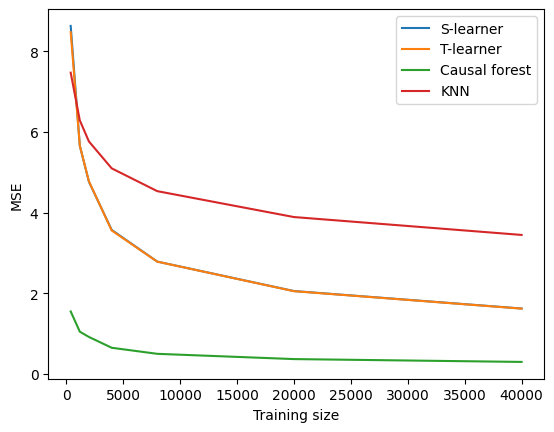

In [10]:
plot_mse(training_sizes, mse_s_list, mse_t_list, mse_forest_list, mse_knn_list)

In [11]:
get_conf_intervals(mse_s_list, mse_t_list, mse_forest_list, mse_knn_list)

,Mean,Std dev
S-Learner,1.622358,0.108346
T-Learner,1.619809,0.108979
Causal Forest,0.298709,0.013835
KNN,3.446400,0.055719


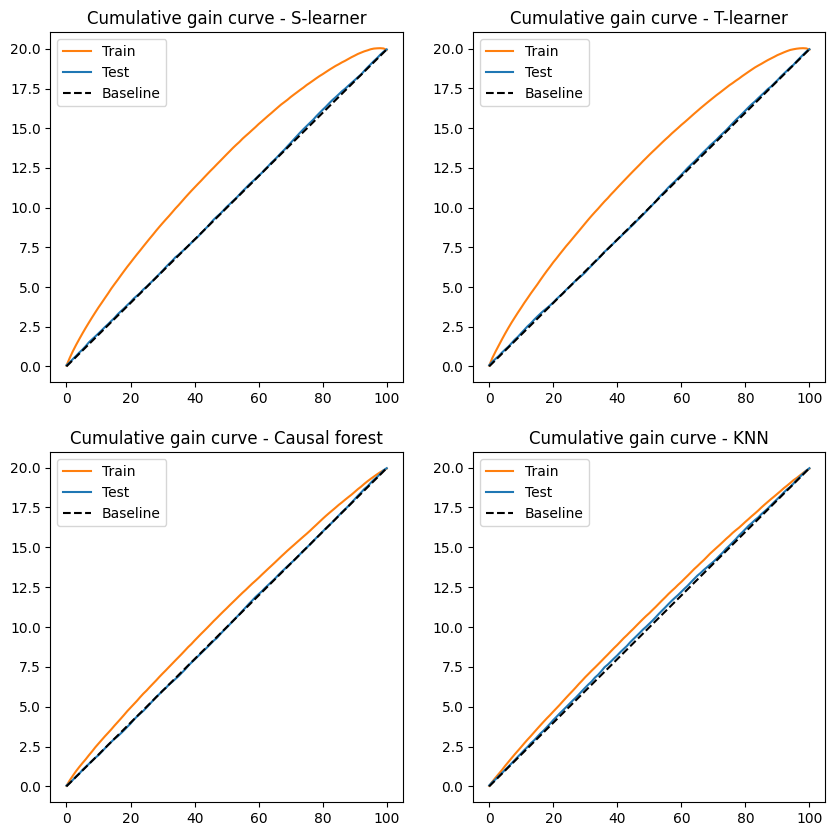

In [12]:
plot_gain_curves(d, mu_0, mu_1, e, n_train, n_test)

# Case 2

Unbalanced, simple cate

In [13]:
e = lambda x: 0.01
d = 10
weights = np.random.uniform(-5, 5, d)
mu_0 = lambda x: np.dot(x, weights) + 5 * (1 if x[0] > 0.5 else 0)
mu_1 = lambda x: mu_0(x) + 8 * (1 if x[1] > 0.1 else 0)
n_train = 40000
n_test = 10000
reps = 50

In [14]:
training_sizes, mse_s_list, mse_t_list, mse_forest_list, mse_knn_list = run_test(d, mu_0, mu_1, e, n_train, n_test, reps)

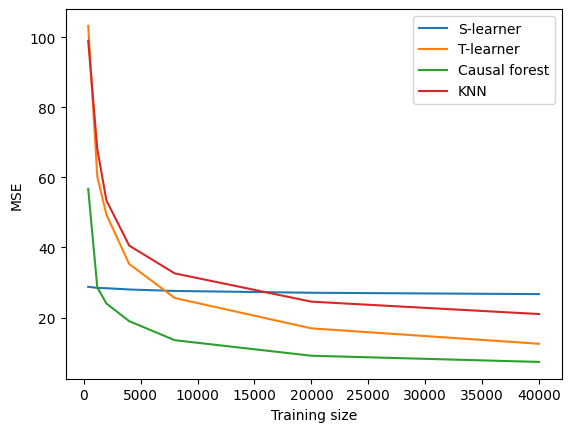

In [15]:
plot_mse(training_sizes, mse_s_list, mse_t_list, mse_forest_list, mse_knn_list)

In [16]:
get_conf_intervals(mse_s_list, mse_t_list, mse_forest_list, mse_knn_list)

,Mean,Std dev
S-Learner,26.685651,0.422544
T-Learner,12.507368,1.260588
Causal Forest,7.327326,0.759848
KNN,20.992985,1.709321


invalid value encountered in scalar divide


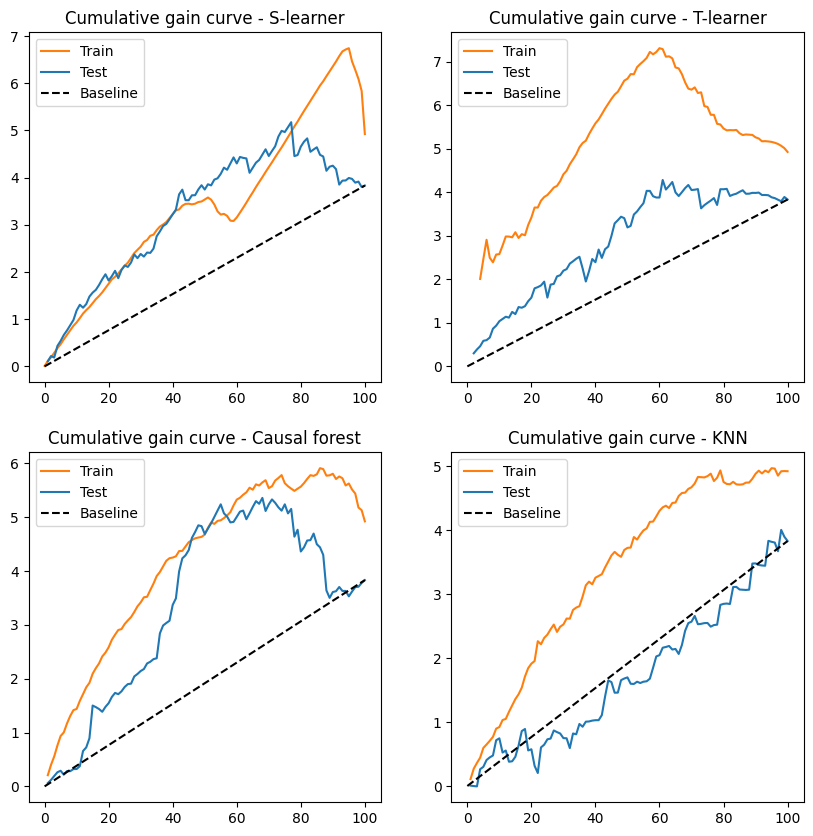

In [17]:
plot_gain_curves(d, mu_0, mu_1, e, n_train, n_test)

# Case 3

Balanced, complex linear cate, no confounding

In [18]:
e = lambda x: 0.5
d = 10
weights_1 = np.random.uniform(1, 30, d)
weights_2 = np.random.uniform(1, 30, d)
mu_0 = lambda x: np.dot(x, weights_1)
mu_1 = lambda x: np.dot(x, weights_2)
n_train = 40000
n_test = 10000
reps = 50

In [19]:
training_sizes, mse_s_list, mse_t_list, mse_forest_list, mse_knn_list = run_test(d, mu_0, mu_1, e, n_train, n_test, reps)

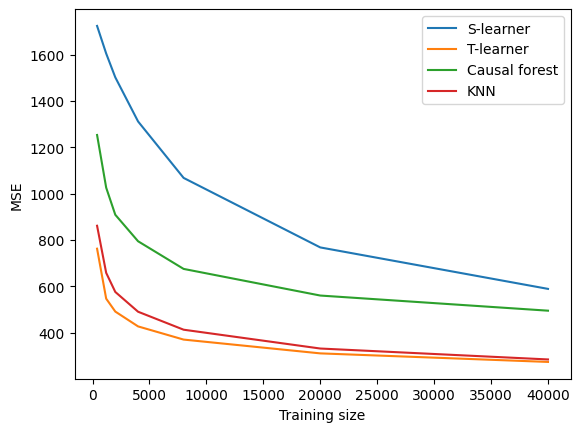

In [20]:
plot_mse(training_sizes, mse_s_list, mse_t_list, mse_forest_list, mse_knn_list)

In [21]:
get_conf_intervals(mse_s_list, mse_t_list, mse_forest_list, mse_knn_list)

,Mean,Std dev
S-Learner,588.688146,18.472468
T-Learner,273.113042,8.330288
Causal Forest,494.498894,11.054655
KNN,283.804618,4.813079


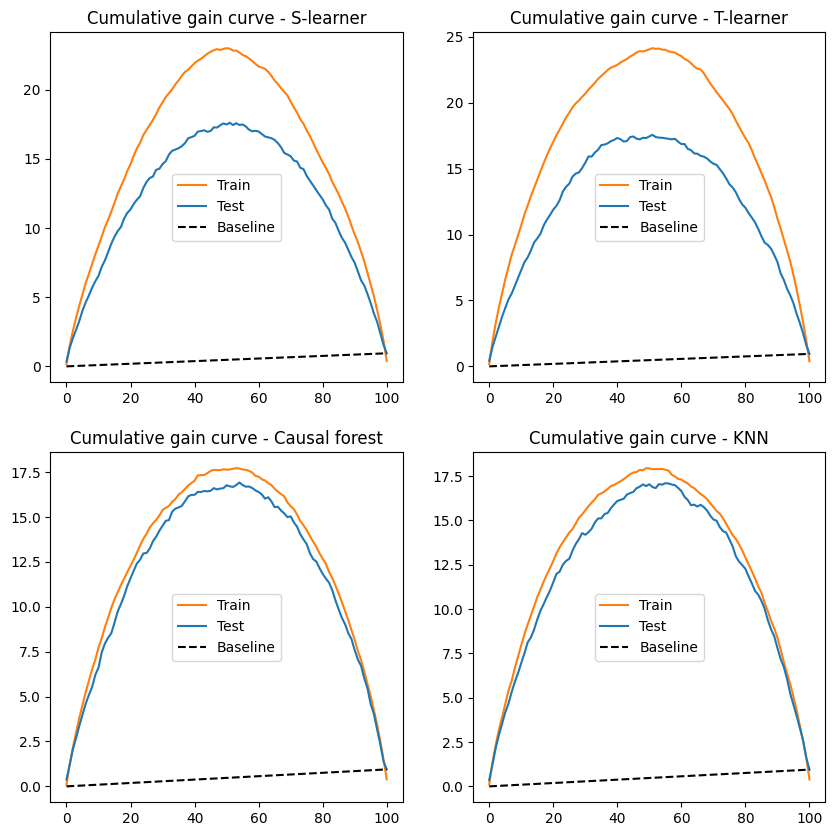

In [22]:
plot_gain_curves(d, mu_0, mu_1, e, n_train, n_test)

# Case 4

Balanced, complex non-liner cate (smoother version), no confounding

In [8]:
e = lambda x: 0.5
d = 10
fun = lambda x : 1.0 + (1.0 / (1 + np.exp(-20 * (x - 1.0/3.0))))
mu_0 = lambda x: 0.5 * fun(x[0]) * fun(x[1])
mu_1 = lambda x: -0.5 * fun(x[0]) * fun(x[1])
n_train = 40000
n_test = 10000
reps = 50

In [9]:
training_sizes, mse_s_list, mse_t_list, mse_forest_list, mse_knn_list = run_test(d, mu_0, mu_1, e, n_train, n_test, reps)

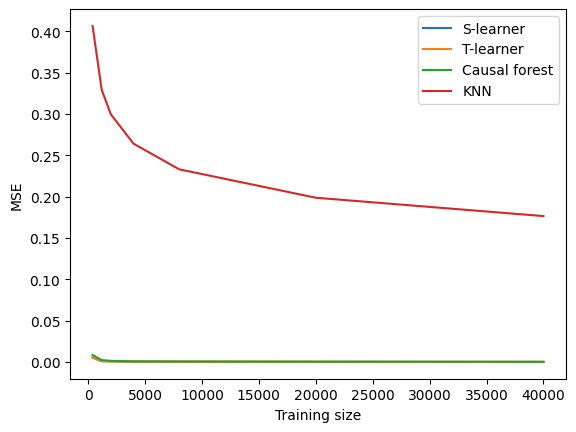

In [10]:
plot_mse(training_sizes, mse_s_list, mse_t_list, mse_forest_list, mse_knn_list)

In [11]:
get_conf_intervals(mse_s_list, mse_t_list, mse_forest_list, mse_knn_list)

,Mean,Std dev
S-Learner,0.000051,0.000011
T-Learner,0.000050,0.000011
Causal Forest,0.000181,0.000054
KNN,0.176521,0.003621


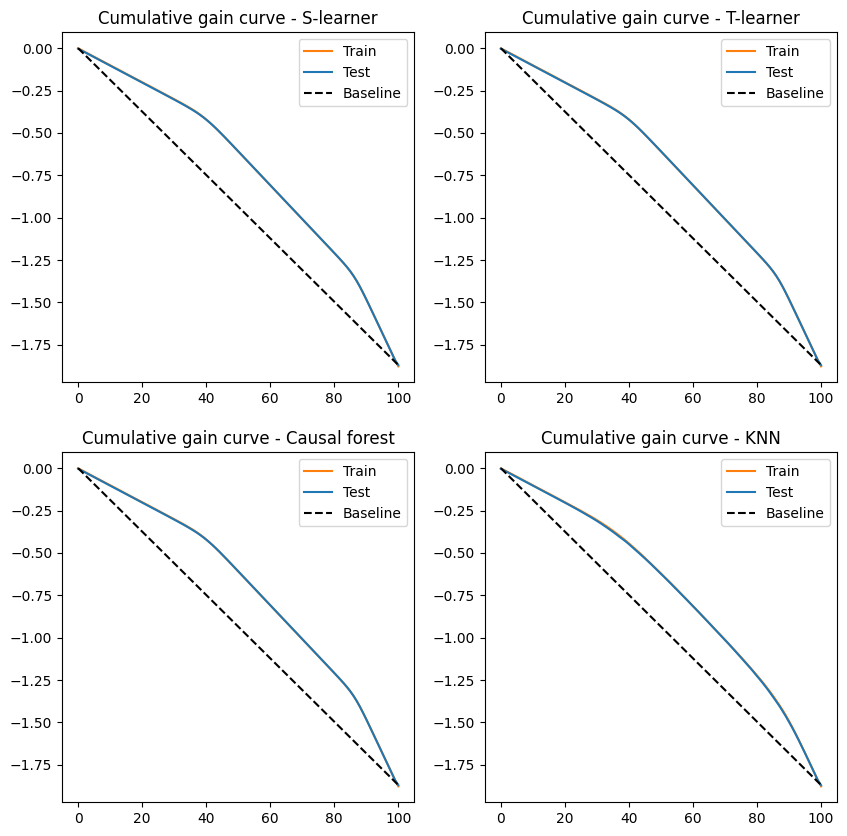

In [12]:
plot_gain_curves(d, mu_0, mu_1, e, n_train, n_test)

# Case 5

Balanced, complex non-liner cate (sharper spike), no confounding

In [23]:
e = lambda x: 0.5
d = 10
fun = lambda x : 2.0 / (1 + np.exp(-12 * (x - 0.5)))
mu_0 = lambda x: 0.5 * fun(x[0]) * fun(x[1])
mu_1 = lambda x: -0.5 * fun(x[0]) * fun(x[1])
n_train = 40000
n_test = 10000
reps = 50

In [24]:
training_sizes, mse_s_list, mse_t_list, mse_forest_list, mse_knn_list = run_test(d, mu_0, mu_1, e, n_train, n_test, reps)

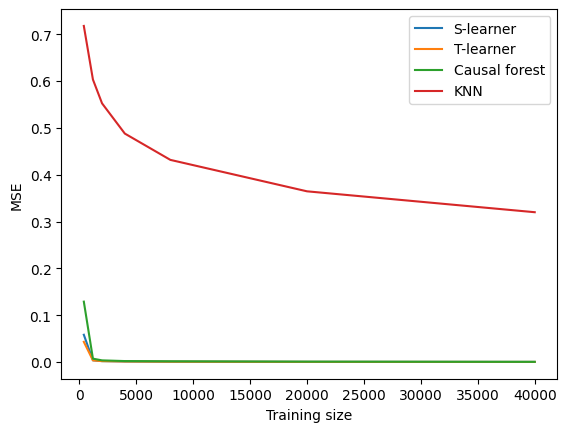

In [25]:
plot_mse(training_sizes, mse_s_list, mse_t_list, mse_forest_list, mse_knn_list)

In [26]:
get_conf_intervals(mse_s_list, mse_t_list, mse_forest_list, mse_knn_list)

,Mean,Std dev
S-Learner,0.000066,0.000010
T-Learner,0.000066,0.000010
Causal Forest,0.000204,0.000031
KNN,0.319923,0.009941


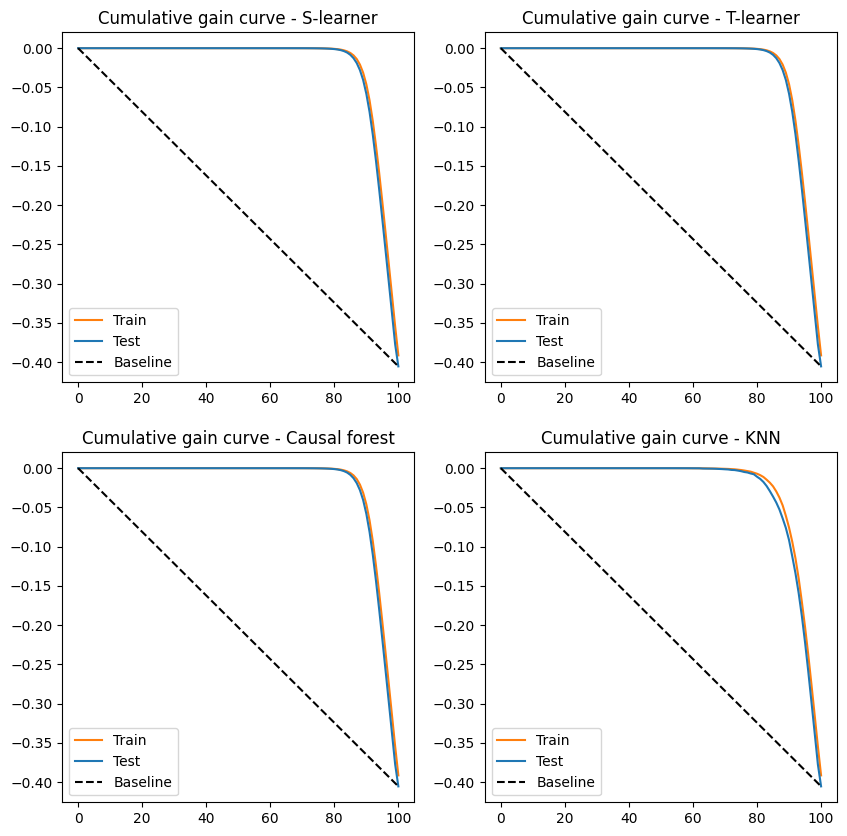

In [27]:
plot_gain_curves(d, mu_0, mu_1, e, n_train, n_test)

# Case 6

Balanced, no treatment effect

In [28]:
e = lambda x: 0.5
d = 10
weights = np.random.uniform(1, 30, d)
mu_0 = lambda x: np.dot(x, weights)
mu_1 = lambda x: mu_0(x)
n_train = 40000
n_test = 10000
reps = 50

In [29]:
training_sizes, mse_s_list, mse_t_list, mse_forest_list, mse_knn_list = run_test(d, mu_0, mu_1, e, n_train, n_test, reps)

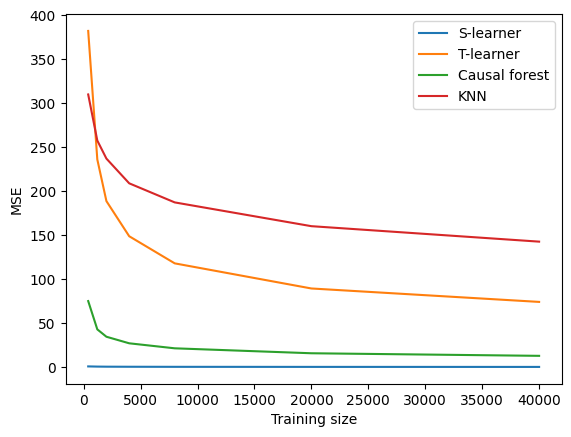

In [30]:
plot_mse(training_sizes, mse_s_list, mse_t_list, mse_forest_list, mse_knn_list)

In [31]:
get_conf_intervals(mse_s_list, mse_t_list, mse_forest_list, mse_knn_list)

,Mean,Std dev
S-Learner,0.222460,0.007627
T-Learner,74.132671,4.641338
Causal Forest,12.823393,0.583202
KNN,142.641164,2.487888


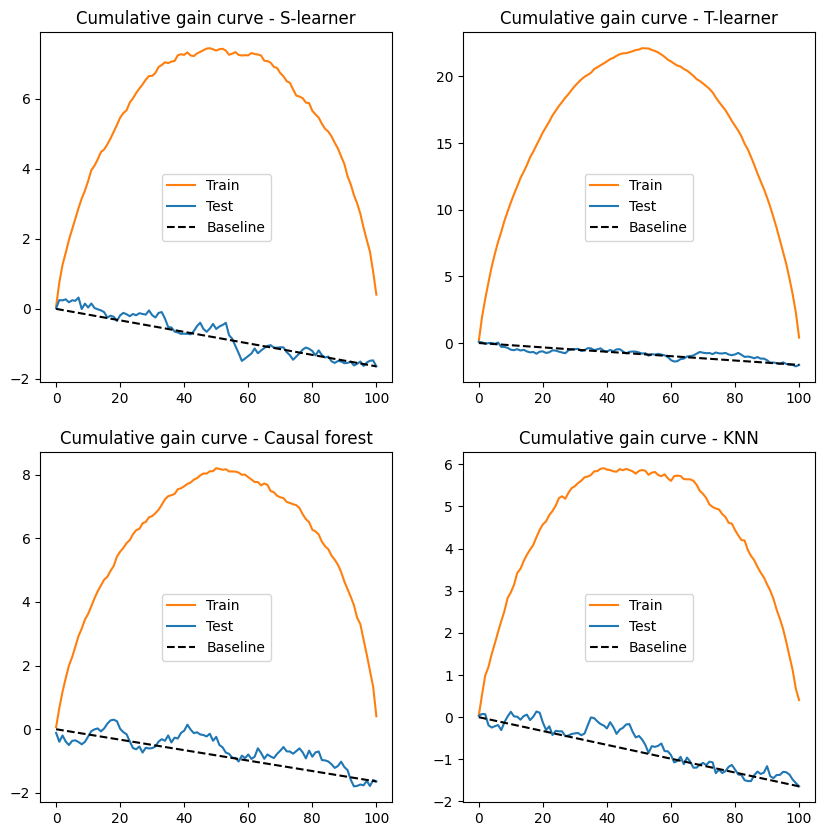

In [32]:
plot_gain_curves(d, mu_0, mu_1, e, n_train, n_test)

# Case 7

Balanced, no treatment effect, piecewise function

In [33]:
e = lambda x: 0.5
d = 16
weights_1 = np.concatenate((np.random.uniform(-15, 15, 4), [0 for _ in range(12)]))
weights_2 = np.concatenate(([0,0,0,0], np.random.uniform(-15, 15, 4), [0 for _ in range(8)]))
weights_3 = np.concatenate(([0 for _ in range(8)], np.random.uniform(-15, 15, 4), [0,0,0,0]))
def mu_0(x):
    if x[15] < -0.4:
        return np.dot(x, weights_1)
    elif x[15] < 0.4:
        return np.dot(x, weights_2)
    else:
        return np.dot(x, weights_3)
mu_1 = lambda x: mu_0(x)
n_train = 40000
n_test = 10000
reps = 50

In [34]:
training_sizes, mse_s_list, mse_t_list, mse_forest_list, mse_knn_list = run_test(d, mu_0, mu_1, e, n_train, n_test, reps)

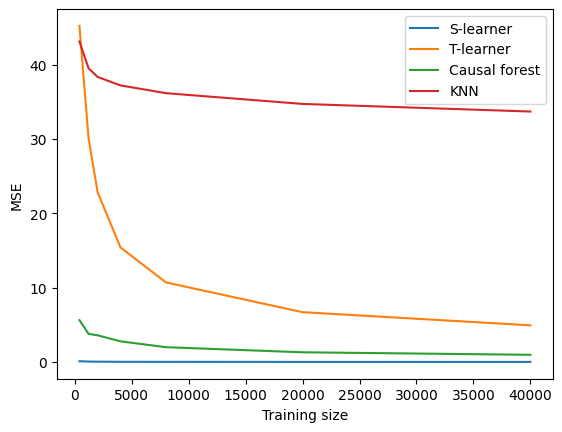

In [35]:
plot_mse(training_sizes, mse_s_list, mse_t_list, mse_forest_list, mse_knn_list)

In [36]:
get_conf_intervals(mse_s_list, mse_t_list, mse_forest_list, mse_knn_list)

,Mean,Std dev
S-Learner,0.007055,0.000466
T-Learner,4.930572,0.446483
Causal Forest,0.965664,0.061154
KNN,33.689342,0.593981


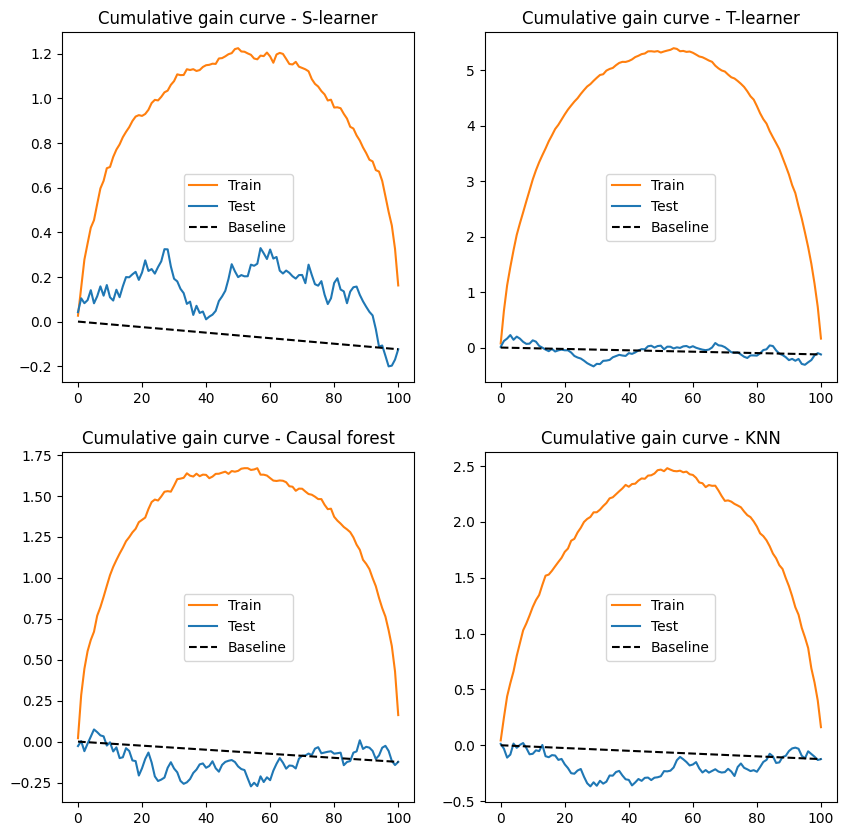

In [37]:
plot_gain_curves(d, mu_0, mu_1, e, n_train, n_test)

# Case 8

Confounding

In [38]:
e = lambda x: 0.25 * (1 + beta(2, 4).pdf(x[0]))
d = 10
mu_0 = lambda x: 2 * x[0] - 1
mu_1 = lambda x: mu_0(x)
n_train = 40000
n_test = 10000
reps = 50

In [39]:
training_sizes, mse_s_list, mse_t_list, mse_forest_list, mse_knn_list = run_test(d, mu_0, mu_1, e, n_train, n_test, reps)

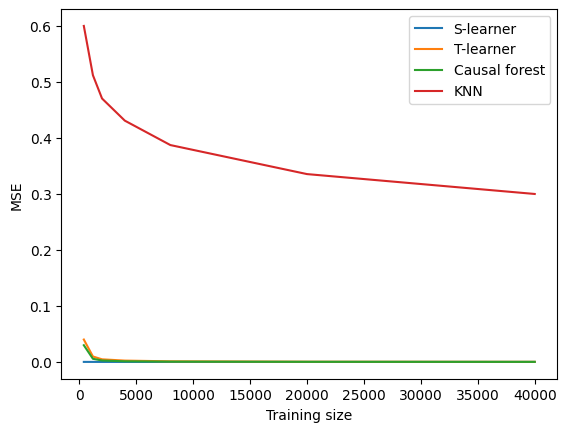

In [40]:
plot_mse(training_sizes, mse_s_list, mse_t_list, mse_forest_list, mse_knn_list)

In [41]:
get_conf_intervals(mse_s_list, mse_t_list, mse_forest_list, mse_knn_list)

,Mean,Std dev
S-Learner,9.263583e-08,2.018314e-07
T-Learner,1.753737e-04,1.518835e-04
Causal Forest,7.665735e-05,6.321406e-05
KNN,2.997539e-01,6.019228e-03


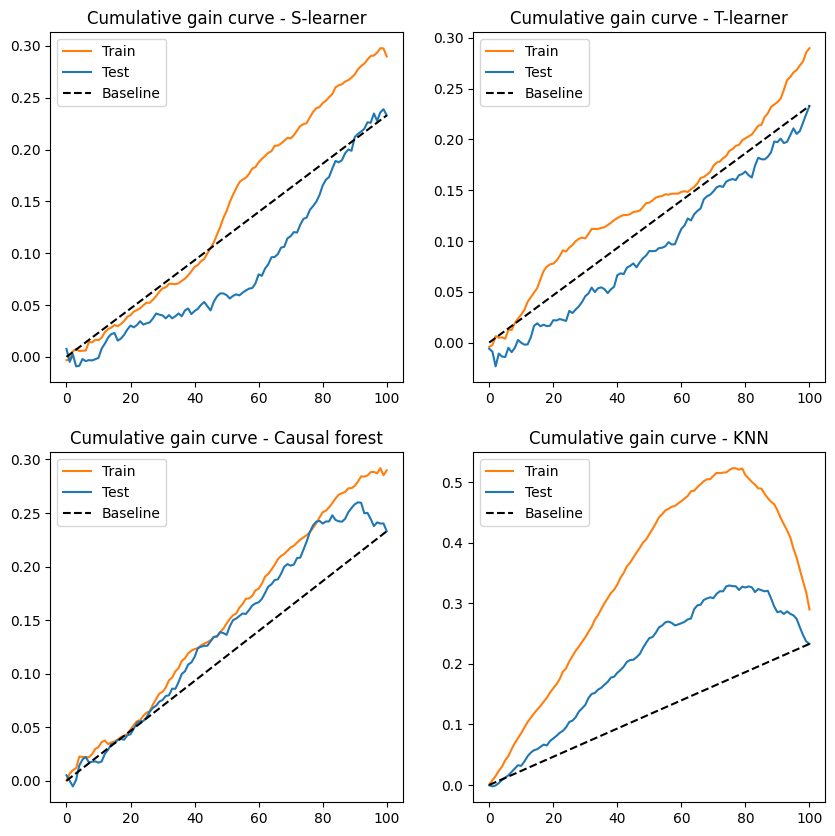

In [42]:
plot_gain_curves(d, mu_0, mu_1, e, n_train, n_test)

# Case 9

MIMIC-like?

In [2]:
d = 23
vars = random.sample(range(d), k=5)
e = lambda x: sum(list(map(lambda v: 0.05 if x[v] * ((-1) ** (v+1)) >=0 else 0, vars)))
weights_lin = np.random.uniform(-10,10,d)
weights_lin_inc = np.random.uniform(-3,3,d)
weights_sq = np.random.uniform(-5,5,d)
weights_sq_inc = np.random.uniform(-1,1,d)
fun1 = lambda x : 2.0 / (1 + np.exp(-12 * (x - 0.5)))
fun2 = lambda x : 1.0 + (1.0 / (1 + np.exp(-20 * (x - 1.0/3.0))))

mu_0 = lambda x: np.dot(weights_lin, x) + np.dot(weights_sq, list(map(lambda a: a*a, x))) + fun1(x[0]) * fun1(x[1])
mu_1 = lambda x: mu_0(x) + np.dot(weights_lin_inc, x) + np.dot(weights_sq_inc, list(map(lambda a: a*a, x))) + fun2(x[-1]) * fun2(x[-2])
n_train = 40000
n_test = 10000
reps = 50

In [6]:
# Sanity check for propensity score
example_data = pd.DataFrame(simulate_data.get_training_set(d, mu_0, mu_1, e, n_train))
example_data["W"].mean()

0.126225

In [14]:
training_sizes, mse_s_list, mse_t_list, mse_forest_list, mse_knn_list = run_test(d, mu_0, mu_1, e, n_train, n_test, reps)

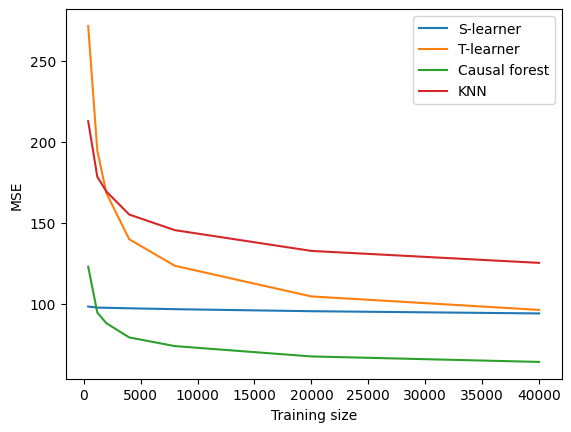

In [15]:
plot_mse(training_sizes, mse_s_list, mse_t_list, mse_forest_list, mse_knn_list)

In [16]:
get_conf_intervals(mse_s_list, mse_t_list, mse_forest_list, mse_knn_list)

,Mean,Std dev
S-Learner,94.087409,1.581818
T-Learner,96.276788,5.578930
Causal Forest,64.180532,1.571390
KNN,125.275545,2.152052


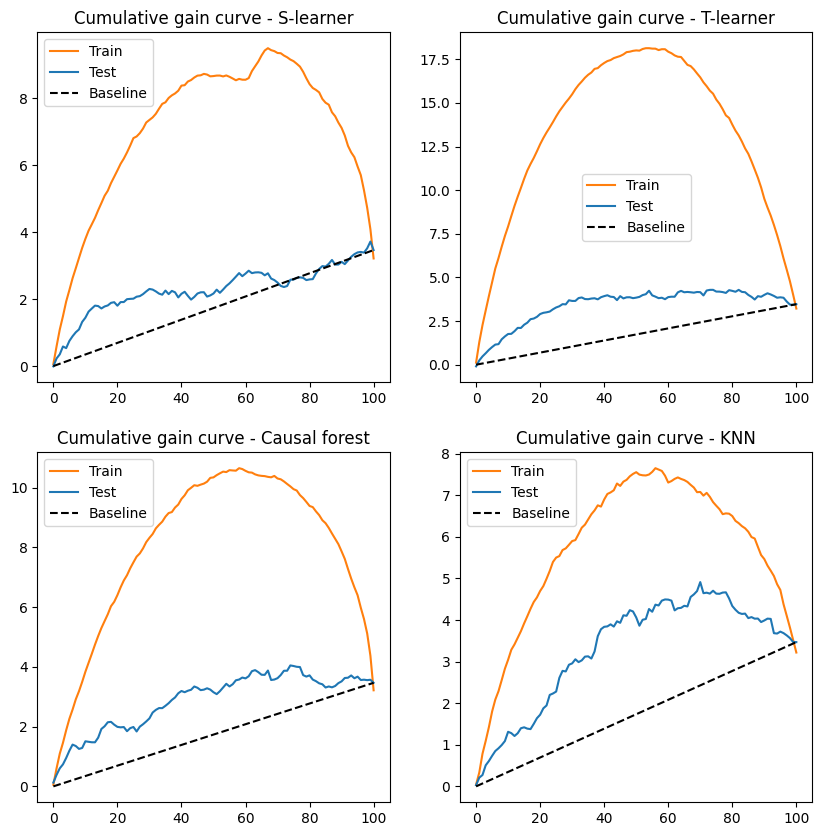

In [17]:
plot_gain_curves(d, mu_0, mu_1, e, n_train, n_test)